# Automaty komórkowe - modelowanie epidemii

Źródła:

https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology

https://en.wikipedia.org/wiki/Epidemic_models_on_lattices

https://www.maa.org/press/periodicals/loci/joma/the-sir-model-for-spread-of-disease-the-differential-equation-model

https://www.nature.com/articles/s41598-020-80007-8

https://www.maa.org/press/periodicals/loci/joma/the-sir-model-for-spread-of-disease-the-differential-equation-model

### Model SIR (susceptible-infected-resistant)
Populacja podzielona na następujące trzy klasy:

- $S$ - osobniki zdrowe podatne na zainfekowanie
- $I$ - osobniki chorujące i roznoszące infekcję
- $R$ - osobniki odporne na infekcję (ozdrowiałe) lub zmarłe

Model korzysta z równań różniczkowych. Jest dobrze przewidywalny w przypadku chorób przenoszonych z człowieka na człowieka, w przypadku których powrót do zdrowia zapewnia trwałą odporność.

Wg najnowszych badań, organizmy osób, które wyzdrowiały po zakażeniu koronawirusem, cechują się pamięcią immunologiczną mogącą utrzymywać się nawet przez osiem miesięcy od zachorowania. Ryzyko reinfekcji jest trudne do oszacowania m.in. ze względu na bezobjawowe przebycie choroby przez część społeczeństwa.

#### Dynamika epidemii
Ponieważ dynamika zachorowań jest znacznie szybsza niż dynamika śmierci i narodzin, w naszym modelu pominiemy je.

Nasz model epidemii opisują następujące równania różniczkowe:

$ \frac{dS}{dt} = -\frac{\beta IS}{N}, $

$ \frac{dI}{dt} = \frac{\beta IS}{N} - \gamma I, $

$ \frac{dR}{dt} = \gamma I, $

gdzie:

$N - $całkowita populacja,

$\beta -$ liczba kontaktów osoby chorej ze zdrowymi w jednostce czasu (infection rate),

$ \gamma - $ prawdopodobieństwo, że zainfekowana jednostka wyzdrowieje/umrze (recovery rate)

$\frac{1}{\gamma} - $ okres zaraźliwości

##### Współczynnik reprodukcji 
określa liczbę nowych infekcji pochodzących od jednego zainfekowanego

$R_{0} = \frac{\beta}{\gamma}$


Przyjmuję, że czas trwania choroby wynosi 20 dni ($\frac{1}{\gamma} = 20 , \gamma = 0.05$).

## Automat komórkowy

$k-$ część populacji, jaka przemieści się (losowo)

$\beta -$ współczynnik infekcji (prawd., że zakażona komórka zarazi komórkę sąsiednią)

$I_{0} - $ liczba chorych na początku 

$N - $całkowita populacja

$w,h - $ rozmiary automatu ($N = w \cdot h$)

$ \gamma - $ prawdopodobieństwo, że zainfekowana jednostka wyzdrowieje/umrze (recovery rate)

$\frac{1}{\gamma} - $ okres zaraźliwości

## Case 1.
Załóżmy, że na początku jest $1$ osoba chora, choroba trwa $20$ dni, populacja liczy $100$ osób, przemieszcza się $5\%$ z nich, współczynnik infekcji to $0,3$.

$0$ - komórka zdrowa ($S$)

$1$ - komórka zainfekowana ($I$)

$2$ - komórka odporna ($R$)

In [1]:
w = 10
h = 10

k = 0.05
beta = 0.3
gamma = 1.0/20
I_0 = 1

N = w * h
to_move = Int64(k * N)

5

In [2]:
function initialize(I_0, w, h)
    arr = zeros(Int64, (w,h))
    infected = 0
    
    while infected != I_0
        x = rand(1:w)
        y = rand(1:h)
        if arr[x,y] == 0
            arr[x,y] = 1
            infected += 1
        end
    end
    return arr
end

initialize (generic function with 1 method)

In [3]:
function ngh_to_infect(x,y,w,h)
    # directions
    dir_x = [0,1,1,1,0,-1,-1,-1]
    dir_y = [1,1,0,-1,-1,-1,0,1]
        
    while true
        i = rand(1:8)
        new_x = x + dir_x[i]
        new_y = y + dir_y[i]
        if new_x >= 1 && new_x <= w && new_y >= 1 && new_y <= h
            return (new_x,new_y)
        end
    end
end

ngh_to_infect (generic function with 1 method)

In [4]:
function move(arr, to_move, w, h)
    for i in 1:to_move
        x1 = rand(1:w)
        x2 = rand(1:w)
        y1 = rand(1:h)
        y2 = rand(1:h)

        arr[x1,y1],arr[x2,y2] = arr[x2,y2],arr[x1,y1]
    end
    return arr
end

move (generic function with 1 method)

### Test

In [5]:
function run(arr, to_move, w, h, i)
#     println("day: ", i)
    
    arr = move(arr, to_move, w, h)
    
    new_arr = arr
    for i in 1:h
        for j in 1:w
            current = arr[i,j]
            
            if current == 1
                # recovery rate
                if rand(0:0.000001:1) < gamma
                    new_arr[i,j] = 2
                end
            else 
                # infection rate
                r = rand(0:0.000001:1)
                if r < beta  
                    new_x,new_y = ngh_to_infect(i,j,w,h)
                    if arr[new_x,new_y] == 0
                        new_arr[new_x,new_y] = 1
                    end
                end
            end
        end
    end
#     display(new_arr)
#     println()
    return new_arr
end

run (generic function with 1 method)

### Stats

In [6]:
function count_stats(arr,w,h)
    S = I = R = 0
    for i in 1:h
        for j in 1:w
            current = arr[i,j]
            if current == 0
                S += 1
            elseif current == 1
                I += 1
            else
                R += 1
            end
        end
    end
#     println(S," ",I," ",R)
    push!(s_stats,S)
    push!(i_stats,I)
    push!(r_stats,R)
end
      

count_stats (generic function with 1 method)

### Plot heatmap

In [7]:
using Plots

In [8]:
w = 10
h = 10

k = 0.05
beta = 0.3
gamma = 1.0/20
I_0 = 1

N = w * h
to_move = Int64(k * N)

5

┌ Info: Saved animation to 
│   fn = D:\studia\sem4\MOwNiT\lab\lab7\case1.gif
└ @ Plots C:\Users\sylwi\.julia\packages\Plots\SjqWU\src\animation.jl:104


Plots.AnimatedGif("D:\\studia\\sem4\\MOwNiT\\lab\\lab7\\case1.gif")
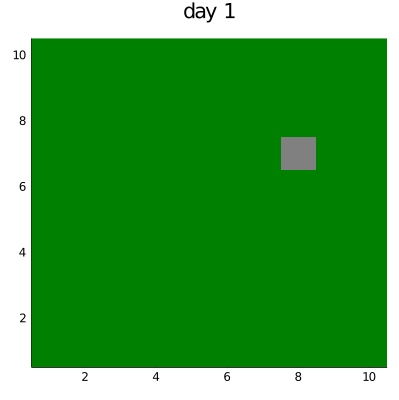

In [9]:
s_stats = Array{Int}(undef, 0)
i_stats = Array{Int}(undef, 0)
r_stats = Array{Int}(undef, 0)

arr = initialize(I_0,w,h)

anim = @animate  for i in 1:40
    plot(heatmap(arr, c=cgrad([:green, :red, :gray]), legend = :none, title = string("day ", i), size = (400, 400)))
    count_stats(arr,10,10)
    arr = run(arr,to_move,w,h,i)
end

gif(anim, "case1.gif", fps = 4)

### Plot stats

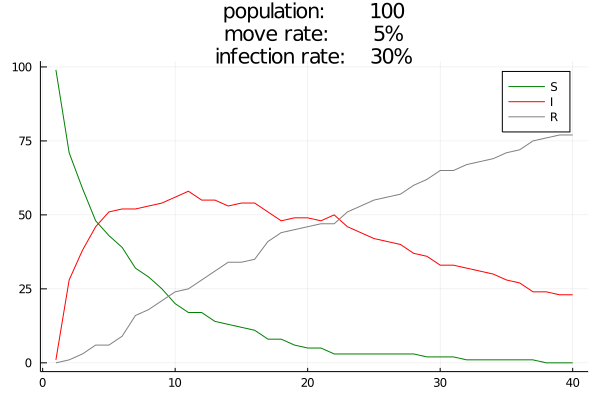

In [10]:
plot(s_stats, label = "S", title = "population:       100\nmove rate:       5%\ninfection rate:    30%", color = :green)
plot!(i_stats, label = "I", color = :red) 
plot!(r_stats, label = "R", color = :gray)

## Case 2.
Zwiększmy współczynnik przemieszczania się z $5$ do $30\%$, a współczynnik zaraźliwości z $0,3$ do $0,5$.

In [11]:
w = 10
h = 10

k = 0.3
beta = 0.5
gamma = 1.0/20
I_0 = 1

N = w * h
to_move = Int64(k * N)

30

┌ Info: Saved animation to 
│   fn = D:\studia\sem4\MOwNiT\lab\lab7\case2.gif
└ @ Plots C:\Users\sylwi\.julia\packages\Plots\SjqWU\src\animation.jl:104


Plots.AnimatedGif("D:\\studia\\sem4\\MOwNiT\\lab\\lab7\\case2.gif")
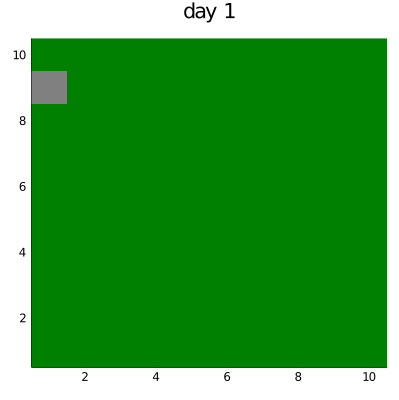

In [12]:
s_stats = Array{Int}(undef, 0)
i_stats = Array{Int}(undef, 0)
r_stats = Array{Int}(undef, 0)

arr = initialize(I_0,w,h)

anim = @animate  for i in 1:40
    plot(heatmap(arr, c=cgrad([:green, :red, :gray]), legend = :none, title = string("day ", i), size = (400, 400)))
    count_stats(arr,10,10)
    arr = run(arr,to_move,w,h,i)
end

gif(anim, "case2.gif", fps = 4)

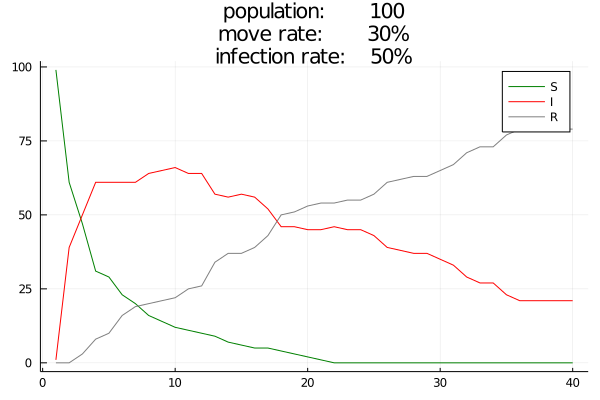

In [13]:
plot(s_stats, label = "S", title = "population:       100\nmove rate:       30%\ninfection rate:    50%", color = :green)
plot!(i_stats, label = "I", color = :red) 
plot!(r_stats, label = "R", color = :gray)

#### Obserwacje:

Zauważalnie wzrosła liczba zakażonych w jednostce czasu, ich wzrost jest o wiele szybszy.  

## Case 3.
Weźmy pod uwagę automat o wymiarach $150x150$. Załóżmy, że na początku jest $1$ osoba chora, choroba trwa $20$ dni, przemieszcza się $10\%$ osób, współczynnik infekcji to $0,1$.

In [14]:
w = 150
h = 150

k = 0.1
beta = 0.1
gamma = 1.0/20
I_0 = 1

N = w * h
to_move = Int64(k * N)

2250

┌ Info: Saved animation to 
│   fn = D:\studia\sem4\MOwNiT\lab\lab7\case3.gif
└ @ Plots C:\Users\sylwi\.julia\packages\Plots\SjqWU\src\animation.jl:104


Plots.AnimatedGif("D:\\studia\\sem4\\MOwNiT\\lab\\lab7\\case3.gif")
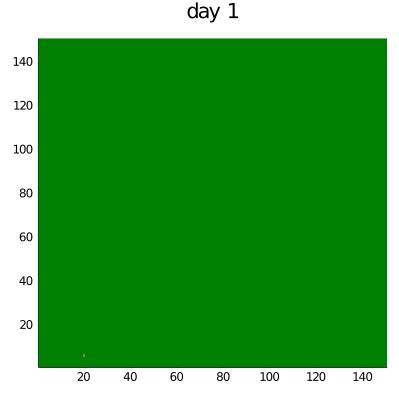

In [15]:
s_stats = Array{Int}(undef, 0)
i_stats = Array{Int}(undef, 0)
r_stats = Array{Int}(undef, 0)

arr = initialize(I_0,w,h)

anim = @animate  for i in 1:40
    plot(heatmap(arr, c=cgrad([:green, :red, :gray]), legend = :none, title = string("day ", i), size = (400, 400)))
    count_stats(arr,150,150)
    arr = run(arr,to_move,w,h,i)
end

gif(anim, "case3.gif", fps = 6)

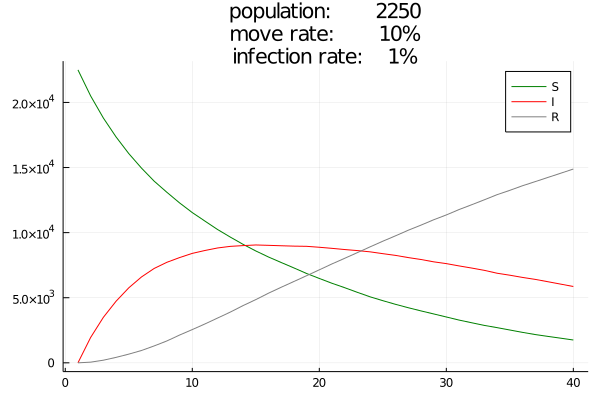

In [16]:
plot(s_stats, label = "S", title = "population:       2250\nmove rate:       10%\ninfection rate:    1%", color = :green)
plot!(i_stats, label = "I", color = :red) 
plot!(r_stats, label = "R", color = :gray)

## Case 4.
Zwiększmy współczynnik infekcji do $0,6$

In [17]:
w = 150
h = 150

k = 0.1
beta = 0.6
gamma = 1.0/20
I_0 = 1

N = w * h
to_move = Int64(k * N)

2250

┌ Info: Saved animation to 
│   fn = D:\studia\sem4\MOwNiT\lab\lab7\case4.gif
└ @ Plots C:\Users\sylwi\.julia\packages\Plots\SjqWU\src\animation.jl:104


Plots.AnimatedGif("D:\\studia\\sem4\\MOwNiT\\lab\\lab7\\case4.gif")
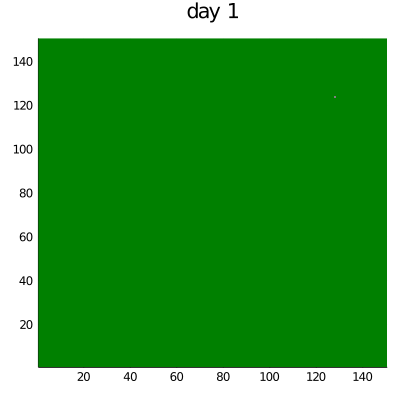

In [18]:
s_stats = Array{Int}(undef, 0)
i_stats = Array{Int}(undef, 0)
r_stats = Array{Int}(undef, 0)

arr = initialize(I_0,w,h)

anim = @animate  for i in 1:40
    plot(heatmap(arr, c=cgrad([:green, :red, :gray]), legend = :none, title = string("day ", i), size = (400, 400)))
    count_stats(arr,150,150)
    arr = run(arr,to_move,w,h,i)
end

gif(anim, "case4.gif", fps = 6)

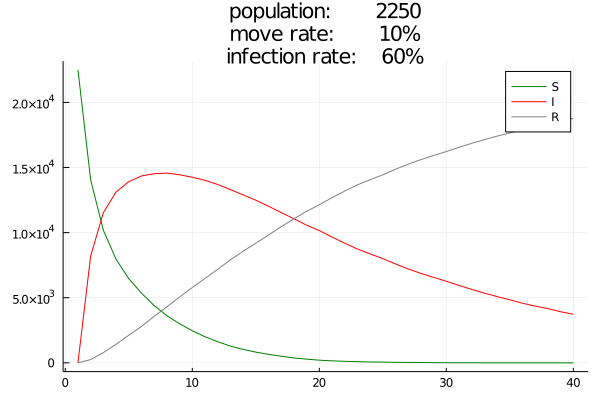

In [19]:
plot(s_stats, label = "S", title = "population:       2250\nmove rate:       10%\ninfection rate:    60%", color = :green)
plot!(i_stats, label = "I", color = :red) 
plot!(r_stats, label = "R", color = :gray)

#### Obseerwacje:
Ponownie liczba zdrowych osób maleje bardzo gwałtownie, o wiele szybciej niż poprzednio.

## Case 5.

Zmniejszymy zarówno współczynnik przemieszczania, jak i infekcji do $1\%$

In [20]:
w = 150
h = 150

k = 0.01
beta = 0.01
gamma = 1.0/20
I_0 = 1

N = w * h
to_move = Int64(k * N)

225

┌ Info: Saved animation to 
│   fn = D:\studia\sem4\MOwNiT\lab\lab7\case5.gif
└ @ Plots C:\Users\sylwi\.julia\packages\Plots\SjqWU\src\animation.jl:104


Plots.AnimatedGif("D:\\studia\\sem4\\MOwNiT\\lab\\lab7\\case5.gif")
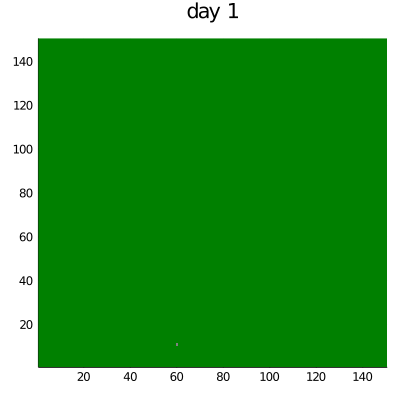

In [21]:
s_stats = Array{Int}(undef, 0)
i_stats = Array{Int}(undef, 0)
r_stats = Array{Int}(undef, 0)

arr = initialize(I_0,w,h)

anim = @animate  for i in 1:100
    plot(heatmap(arr, c=cgrad([:green, :red, :gray]), legend = :none, title = string("day ", i), size = (400, 400)))
    count_stats(arr,150,150)
    arr = run(arr,to_move,w,h,i)
end

gif(anim, "case5.gif", fps = 6)

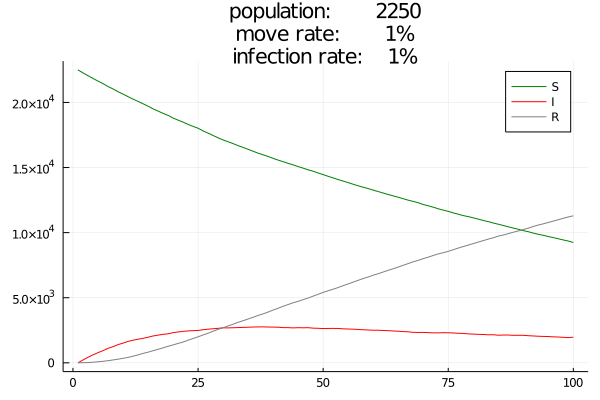

In [22]:
plot(s_stats, label = "S", title = "population:       2250\nmove rate:       1%\ninfection rate:    1%", color = :green)
plot!(i_stats, label = "I", color = :red) 
plot!(r_stats, label = "R", color = :gray)

## Wnioski:
Zwiększenie współczynnika przemieszczania znacząco wpływa na szybkość wzrostu liczby zakażonych w populacji, maksymalna liczba zakażonych w danej jednostce czasu diametralnie wzrasta. Również niczym zaskakującym nie jest ogromna różnica, jeśli chodzi o liczbę zdrowych jednostek, w momencie, gdy współczynnik infekcji wzrósł. 